# Image Segmentation

Image segmentation is a computer vision technique that divides an image into distinct regions, allowing the model to understand and process the image at a more detailed level. In segmentation, each pixel in the image is assigned to a class, like separating the background from objects of interest. This breakdown allows for fine-grained analysis, enabling models to "see" and interpret specific areas.

# There are several types of image segmentation:

Semantic Segmentation: Labels each pixel based on object class without distinguishing between instances. For example, in an image with multiple cars, all car pixels are labeled as "car."

Instance Segmentation: Identifies individual objects, distinguishing between different instances of the same class. If there are multiple cars, each car is uniquely labeled.

Panoptic Segmentation: Combines both semantic and instance segmentation, labeling each pixel while distinguishing between instances.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

#  Oxford-IIIT Pets dataset, that is already included in Tensorflow:

In [6]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\aya.tarek\tensorflow_datasets\oxford_iiit_pet\incomplete.X9IKDD_4.0.0\oxford_iiit_pet-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\aya.tarek\tensorflow_datasets\oxford_iiit_pet\incomplete.X9IKDD_4.0.0\oxford_iiit_pet-test.…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\aya.tarek\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64 #This is the number of samples processed in one training iteration.
BUFFER_SIZE = 1000 #This is the number of samples loaded into memory for shuffling. A larger buffer allows for better mixing of the data, which is beneficial for training.
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

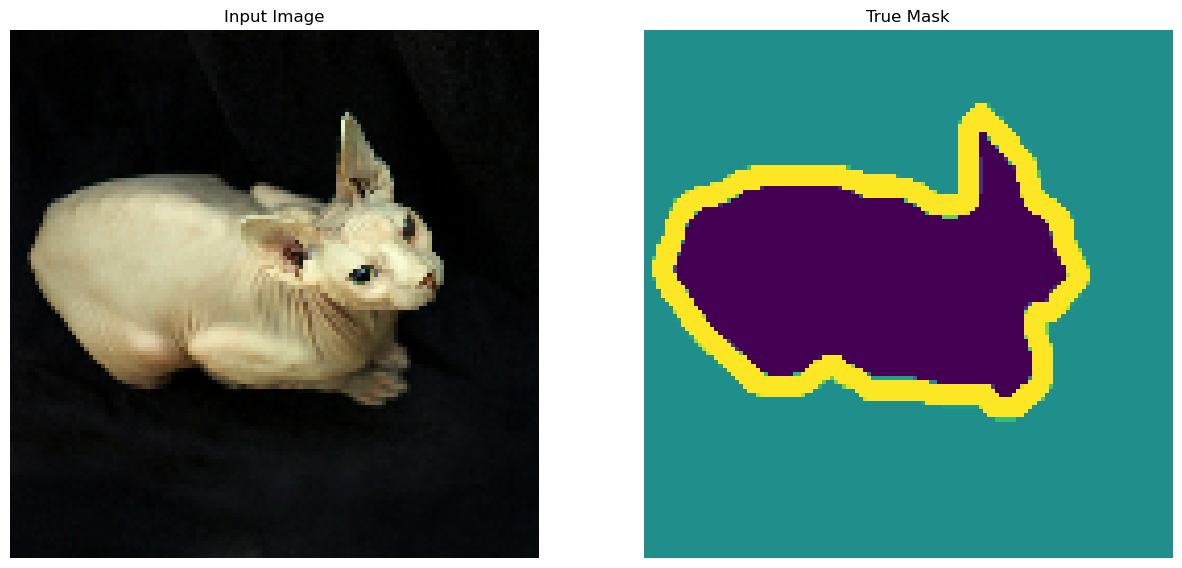

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
  
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Define the Image SegmentationModel

In [10]:
OUTPUT_CHANNELS = 3

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False  #Setting down_stack.trainable = False freezes these layers, preventing updates during training to keep pretrained features intact.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# Upsampling

In [13]:
#Upsampling is crucial in computer vision tasks, especially for generating high-resolution images from low-resolution ones. 
import tensorflow as tf

def upsample(filters, size):
    """Upsamples using Conv2DTranspose, BatchNormalization, and ReLU."""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result


In [14]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


In [15]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Assuming down_stack is defined elsewhere in your code
    skips = down_stack(inputs)  #down_stack: Assumes a predefined encoder (like the feature extraction model) that downsamples the input image and extracts feature maps at different layers. These feature maps are stored in skips.
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):  #up_stack is used to gradually upsample the feature maps back to the original resolution.
        x = up(x)
        concat = tf.keras.layers.Concatenate() #Concatenate merges each upsampled layer with the corresponding skip connection from the encoder to retain fine details.
        x = concat([x, skip])

    # This is the last layer of the model The last Conv2DTranspose layer upsamples to the original image size and outputs the segmented image with the specified output_channels
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [16]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
!pip install pydot

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


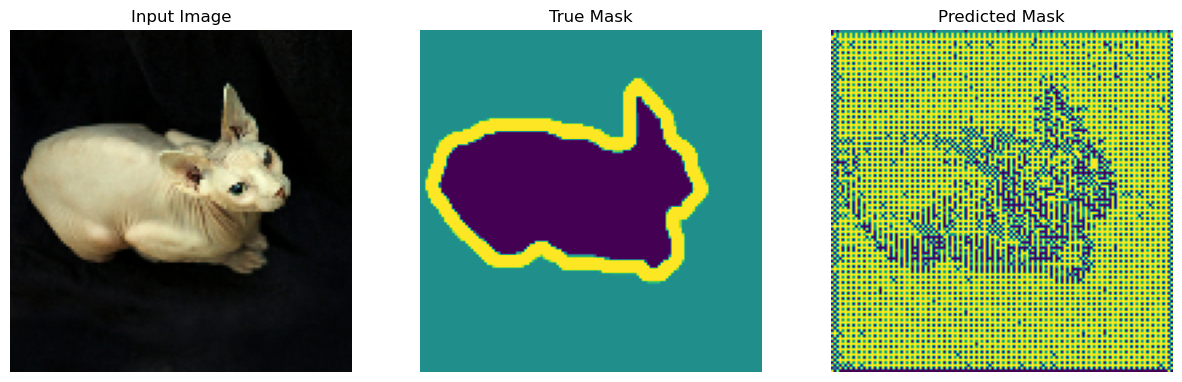

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


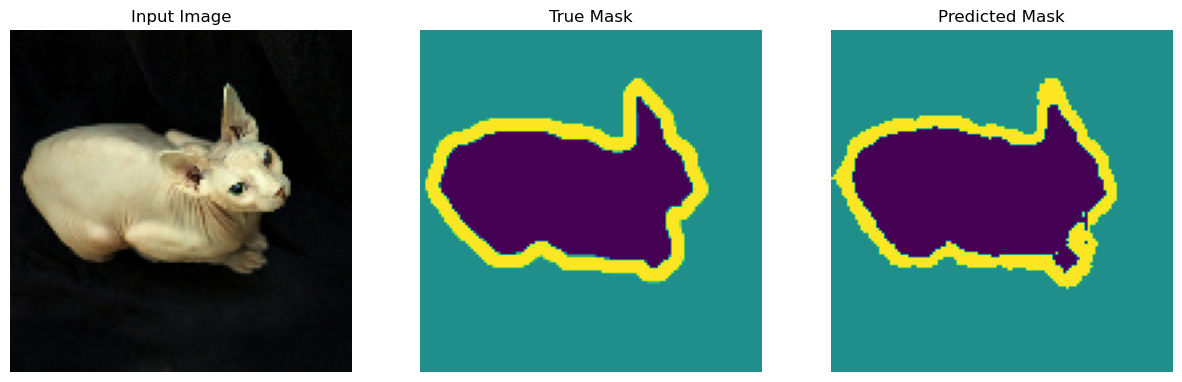


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9381 - loss: 0.1356 - val_accuracy: 0.8937 - val_loss: 0.3036


In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
    
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

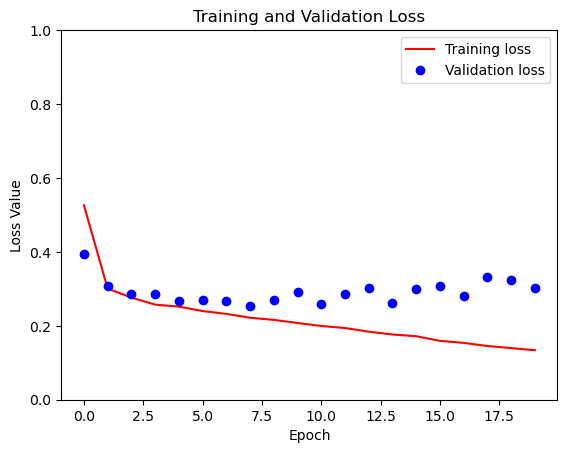

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


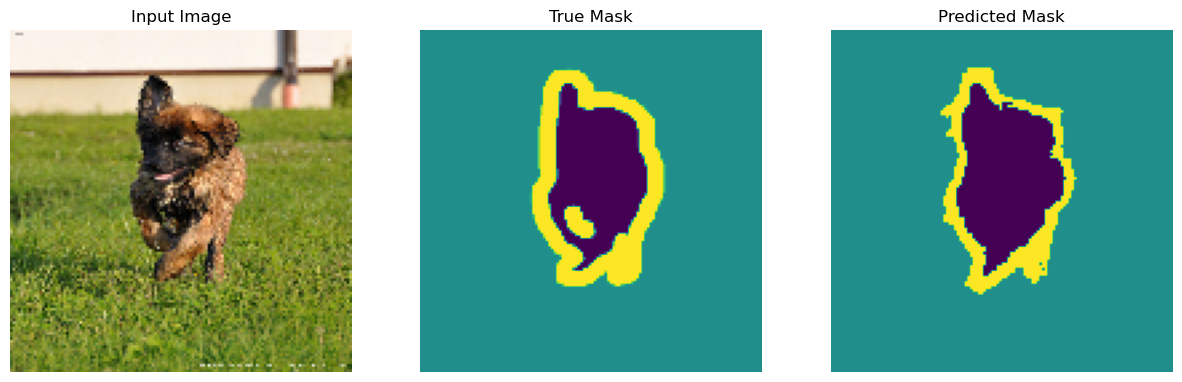

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 983ms/step


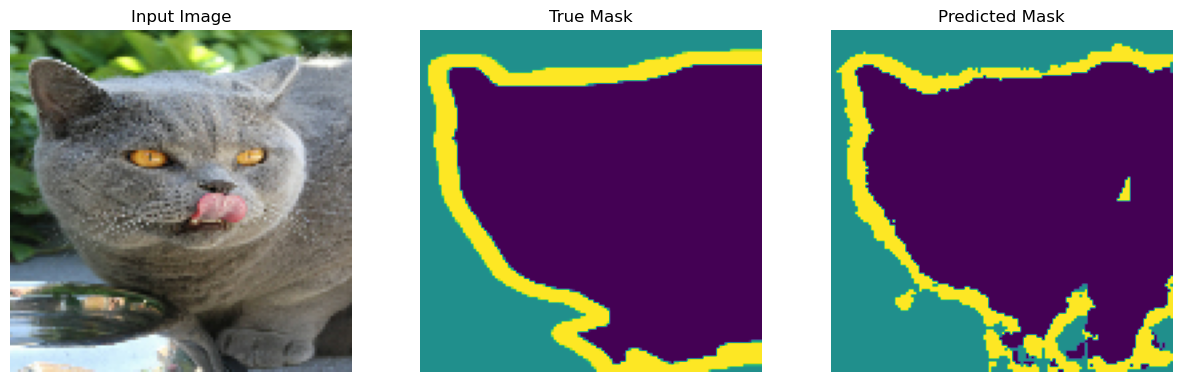

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


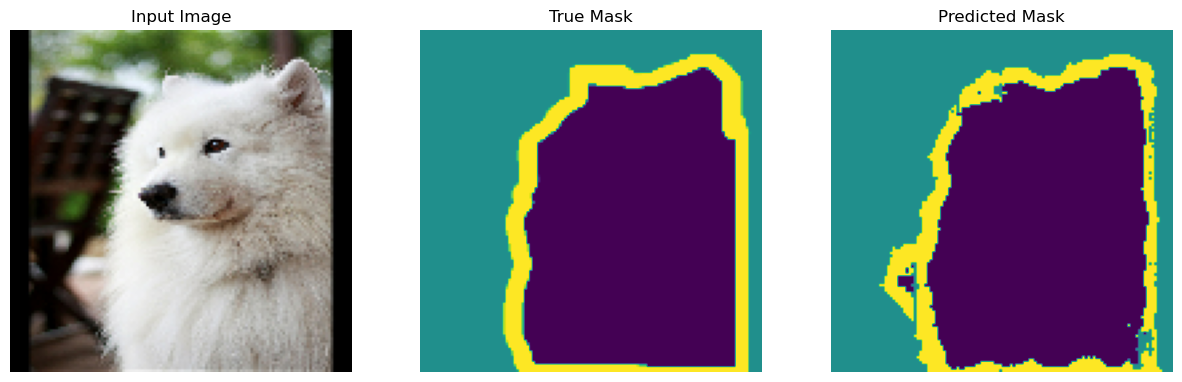

In [24]:
show_predictions(test_dataset, 3)